In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
dataset = 'BigEarthNet'
dataset = 'EuroSAT'
dataset = 'So2Sat'
# dataset = 'OSCD'
models = []
names = []
# models += ['vit_base_patch16_224']
# models += ['cvit_base_patch16_224']
models += ['cvit_p1_base_patch16_224']
# names += ['mae_vit_v2']
# names += ['mae_cvit_v2']
# names += ['mae_base']
# names += ['mae_vit_btnk']
metric = 'micro_mAP' if dataset == 'BigEarthNet' else 'accuracy'
if dataset == 'OSCD':
    # metric = 'precision'
    metric = 'f1'
    # metric = 'recall'

In [3]:
log_path = './results/logs/'
all_logs = os.listdir(log_path)
target_logs = [log for log in all_logs if dataset in log and any([model in log for model in models])]
# print(len(target_logs))
target_logs

['So2Sat_cvit_p1_base_patch16_224_mae_cvit_0-12-0',
 'So2Sat_cvit_p1_base_patch16_224_mae_cvit_0-1-11',
 'So2Sat_cvit_p1_base_patch16_224_mae_cvit_4-4-4',
 'So2Sat_cvit_p1_base_patch16_224_mae_cvit_1-1-10',
 'So2Sat_cvit_p1_base_patch16_224_mae_cvit_0-0-12',
 'So2Sat_cvit_p1_base_patch16_224_mae_cvit_1-0-11']

In [4]:
df_all = pd.DataFrame()
for target_log in target_logs:
    name = '_'.join(target_log.split('_')[-3:])
    try:
        path = f'./results/logs/{target_log}/ft_metrics.csv'
        df = pd.read_csv(path)
        df.sort_values(by=[metric], inplace=True)
    except:
        continue
    # add model name
    df['model'] = name
    df_all = pd.concat([df_all, df], ignore_index=True)
# df_all.sort_values(by=[metric], inplace=True)
# get the best lr for each model
df_all_best = df_all.loc[df_all.groupby('model')[metric].idxmax()]
print(len(df_all))
df_all_best.sort_values(by=[metric])
# df_all

4


,epochs,lr,weight_decay,ce,loss,accuracy,epoch,num_samples,model
3,10,0.0005,0.0005,2.093865,2.093865,0.634152,10,48307,mae_cvit_0-0-12
1,10,0.0005,0.0005,2.214312,2.214312,0.637506,10,48307,mae_cvit_1-1-10


In [5]:
sns.lineplot(data=df_all.loc[df_all.weight_decay==5e-6], x='lr', y=metric, hue='model')
# set x axis log scale
plt.xscale('log')

NameError: name 'df_all' is not defined

In [36]:
df_all = pd.DataFrame()
for target_log in target_logs:
    name = '_'.join(target_log.split('_')[-3:])
    try:
        path = f'./results/logs/{target_log}/lp_metrics.csv'
        df = pd.read_csv(path)
        df.sort_values(by=[metric], inplace=True)
    except:
        continue
    # add model name
    df['model'] = name
    df_all = pd.concat([df_all, df], ignore_index=True)
# df_all.sort_values(by=[metric], inplace=True)
# get the best lr for each model
df_all_best = df_all.loc[df_all.groupby('model')[metric].idxmax()]
# df_all
df_all_best.sort_values(by=[metric])

,epochs,lr,weight_decay,ce,loss,accuracy,epoch,num_samples,model
13,100,0.08,0,0.200129,0.200129,0.935185,100,5400,mae_cvit_0-12-0
34,100,0.08,0,0.188399,0.188399,0.939074,100,5400,mae_cvit_1-1-10
41,100,0.06,0,0.184786,0.184786,0.943889,100,5400,mae_cvit_4-4-4
6,100,0.09,0,0.186212,0.186212,0.944444,100,5400,mae_cvit_1-0-11
20,100,0.10,0,0.186553,0.186553,0.945185,100,5400,mae_cvit_0-0-12
27,100,0.09,0,0.176758,0.176758,0.947407,100,5400,mae_cvit_0-1-11


<Axes: xlabel='lr', ylabel='accuracy'>

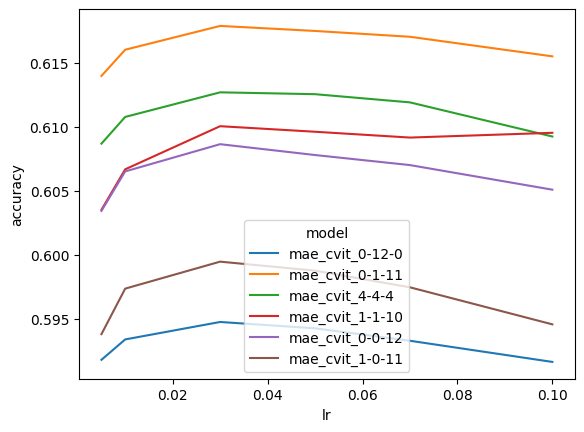

In [48]:
sns.lineplot(data=df_all.loc[df_all.epochs==100], x='lr', y=metric, hue='model')